In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
seed_base(CFG["env"]["seed"])

In [3]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["stacking"]["execution"]["best_exp_id"]}/oof.parquet')
# oof_df = oof_df[oof_df["series_id"].isin(oof_df["series_id"].unique()[:50])]
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004084,0.002020
1,05e1944c3818,18,0.003406,0.001832
2,05e1944c3818,30,0.003180,0.001751
3,05e1944c3818,42,0.003114,0.001701
4,05e1944c3818,54,0.003104,0.001665


886404

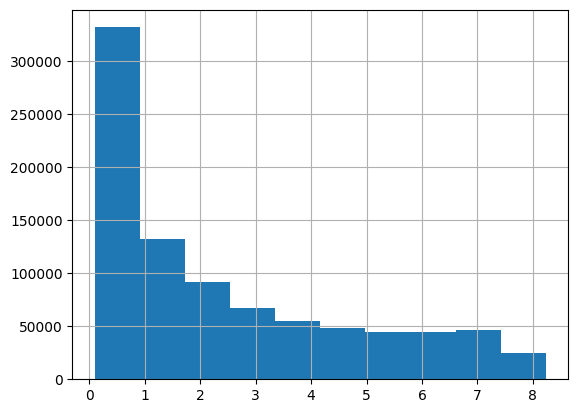

In [4]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.1]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.1]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [5]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import yaml
import matplotlib.pyplot as plt
import gc
from typing import Optional
from scipy.interpolate import interp1d


RANGE = 917
COEFF = 11
EXP = 5

def dynamic_range_nms(df: pd.DataFrame) -> pd.DataFrame:
    """Dynamic-Range NMS

    Parameters
    ----------
    df : pd.DataFrame
        単一のseries_idに対する提出形式
    """
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = []
    used_scores = []
    reduce_rate = np.ones(df["step"].max() + 1000)
    for _ in range(min(len(df), 100)):
        df["reduced_score"] = df["score"] / reduce_rate[df["step"]]
        best_score = df["reduced_score"].max()
        best_idx = df["reduced_score"].idxmax()
        best_step = df.loc[best_idx, "step"]
        used.append(best_idx)
        used_scores.append(best_score)

        for r in range(1, int(RANGE)):
            reduce = ((RANGE - r) / RANGE) ** EXP * COEFF
            reduce_rate[best_step + r] += reduce
            if best_step - r >= 0:
                reduce_rate[best_step - r] += reduce
        reduce_rate[best_step] = 1e10
    df = df.iloc[used].copy()
    df["reduced_score"] = used_scores
    return df


In [6]:
from multiprocessing import Pool
import optuna

def objective(trial):
    global RANGE, COEFF, EXP
    RANGE = trial.suggest_int("RANGE", 100, 1000)
    COEFF = trial.suggest_int("COEFF", 1, 30)
    EXP = trial.suggest_int("EXP", 1, 5)        

    groups = [group for _, group in train.groupby("series_id")]
    with Pool(30) as p:  
        results = list(p.imap(dynamic_range_nms, groups))
    sub = pd.concat(results)
    sub["score"] = sub["reduced_score"]

    # スコア計算
    labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
    # labels = labels[labels["series_id"].isin(sub["series_id"].unique())].reset_index(drop=True)
    score, ap_table = compute_comptetition_metric(labels, sub)
    return score


study = optuna.create_study(direction="maximize")
study.enqueue_trial({"RANGE": 917, "COEFF": 11, "EXP": 5})
study.enqueue_trial({"RANGE": 695, "COEFF": 14, "EXP": 3})
study.enqueue_trial({"RANGE": 360, "COEFF": 10, "EXP": 2})
study.enqueue_trial({"RANGE": 638, "COEFF": 17, "EXP": 3})
study.enqueue_trial({"RANGE": 570, "COEFF": 5, "EXP": 3})
study.optimize(objective, n_trials=60)
print(study.best_params)

[I 2023-11-02 05:06:54,736] A new study created in memory with name: no-name-64fc5157-860b-4998-a377-d435f4b5d93c
[I 2023-11-02 05:07:59,555] Trial 0 finished with value: 0.7441074565524878 and parameters: {'RANGE': 917, 'COEFF': 11, 'EXP': 5}. Best is trial 0 with value: 0.7441074565524878.
[I 2023-11-02 05:09:03,916] Trial 1 finished with value: 0.7448459517374002 and parameters: {'RANGE': 695, 'COEFF': 14, 'EXP': 3}. Best is trial 1 with value: 0.7448459517374002.
[I 2023-11-02 05:10:08,246] Trial 2 finished with value: 0.7375279050429273 and parameters: {'RANGE': 360, 'COEFF': 10, 'EXP': 2}. Best is trial 1 with value: 0.7448459517374002.
[I 2023-11-02 05:11:11,591] Trial 3 finished with value: 0.7446015760834106 and parameters: {'RANGE': 638, 'COEFF': 17, 'EXP': 3}. Best is trial 1 with value: 0.7448459517374002.
[I 2023-11-02 05:12:14,696] Trial 4 finished with value: 0.7402673926818919 and parameters: {'RANGE': 570, 'COEFF': 5, 'EXP': 3}. Best is trial 1 with value: 0.7448459517

---